Figures for paper

In [1]:
import os
import glob

import numpy as np
import xarray as xr

import csv
import pop_tools

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean.cm as cmo

# 1. Explain Events

2 panels:
- One panel with one member over historical period
    - member 1281.015
    - mean period 1 and period 2
    - 3 std line
- One panel with all members over event period
    - choose nice colors

In [56]:
# Define parameters
raw_files = glob.glob(os.path.expanduser('~/phase1_CONDA/') + 'timeseries/*time_series.npy')
h = 7
window_size = 40
duration_threshold = 20
threshold_multiple = 3

# Load signal data for the first plot
signals = np.load(raw_files[7])
hist_end = (2014 - 1850) * 12
signals = signals[:hist_end]
time_annual = np.arange(1850, 1850 + (hist_end / 12))

# Read the order file
with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
    vvel_list = file.readlines()
vvel_dict = {int(line.split()[0]): line.split()[1] for line in vvel_list}

# Load data from 'events_dens_spg.csv' to get member numbers
data = np.genfromtxt('events_dens_spg.csv', delimiter=',', names=True, dtype=None)
member_numbers = data['Index']

# Process data for the first plot
last_member_name = vvel_dict[member_numbers[-3]][5:]
signal = signals[:, member_numbers[-3]][:hist_end]
annual_mean = np.mean(signal.reshape(-1, 12), axis=1)

# Identify events for the second plot
criteria_indices_dict = {}

for i, signal in enumerate(signals.T):
    annual_means = np.mean(signal.reshape(-1, 12), axis=1)
    criteria_indices = []
    for j in range(window_size, len(annual_means) - duration_threshold):
        window = annual_means[j - window_size:j]
        std_window = np.std(window)
        avg_window = np.mean(window)
        threshold = annual_means[j:j + duration_threshold]
        avg_threshold = np.mean(threshold)
        if avg_threshold >= avg_window + (threshold_multiple * std_window) or avg_threshold <= avg_window - (threshold_multiple * std_window):
            if len(criteria_indices) == 0 or j >= criteria_indices[-1] + duration_threshold:
                criteria_indices.append(j)
    criteria_indices_dict[i] = criteria_indices

result = [(index, value) for index, value in criteria_indices_dict.items() if value]

with open('events_dens_spg.csv', 'w', newline='') as csvfile:
    fieldnames = ['Index', 'Values']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for index, values in result:
        writer.writerow({'Index': index, 'Values': values[0]})

# Save event and member names
saved_data = []
for index, values in result:
    file_name = vvel_dict[index][5:-3]
    annual_means = np.mean(signals[:, index].reshape(-1, 12), axis=1)
    start = values[0]
    end = values[0] + duration_threshold
    event = annual_means[start - window_size:end]
    saved_data.append((file_name, event))

sorted_data = sorted(saved_data, key=lambda x: x[0])

120
105
64
141
40
56
55
121
79
41
89
107
57
56


/tmp/ipykernel_1905/1930587356.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0, 1, 1])


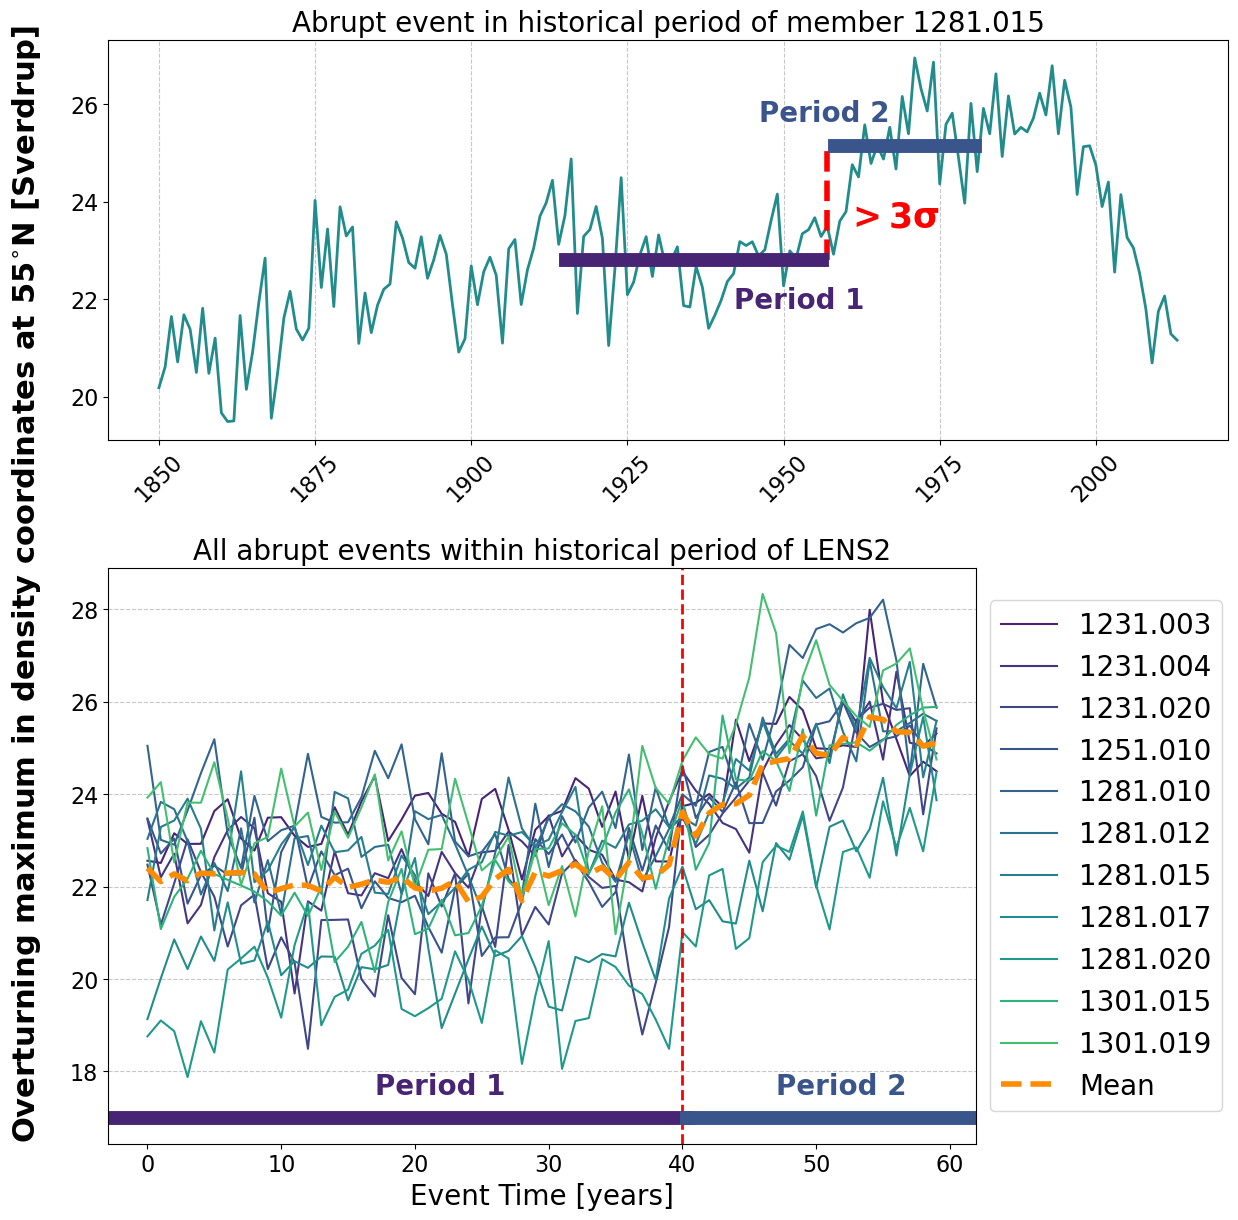

In [232]:
# Create figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 16), gridspec_kw={'height_ratios': [2, 3.2], 'hspace': 0.01})

# Define colormap
colors = cm.viridis(np.linspace(0.1, 0.7, len(sorted_data[1:])))

# Upper subplot
event_location = 107
period_1 = np.mean(annual_mean[event_location - 40: event_location-1])
period_2 = np.mean(annual_mean[event_location+1: event_location + 20])
length = len(annual_mean)

axs[0].plot(time_annual, annual_mean, linewidth=2, color=colors[-5])
axs[0].set_title('Abrupt event in historical period of member ' + last_member_name[:-3], fontsize=20)
axs[0].tick_params(axis='x', labelsize=16, rotation=45)
axs[0].tick_params(axis='y', labelsize=16)
axs[0].locator_params(axis='x', nbins=8)
axs[0].locator_params(axis='y', nbins=5)
axs[0].grid(axis='x', linestyle='--', alpha=0.7)

# Set definition ranges
y_min, y_max = axs[0].get_ylim()
y_length = (y_max - y_min)
axs[0].axvline(x=vertical_position, color='r', linestyle='--', linewidth = 4,
               ymin=(period_1-y_min)/y_length, ymax=(period_2-y_min)/y_length)
axs[0].axhline(y=period_1, color=colors[0], linewidth = 10, 
               xmin=(event_location - 40) / length, xmax=(event_location-2.5) / length)
axs[0].axhline(y=period_2, color=colors[3], linewidth = 10, 
               xmin=(event_location-0.5) / length, xmax=(event_location + 20) / length)

axs[0].text(vertical_position + 3, 0.49 * (period_1 + period_2), r'$\mathbf{> 3 \sigma}$', color='r', fontsize=25)
axs[0].text(vertical_position - 15, 0.455 * (period_1 + period_2), 'Period 1', weight='bold', color=colors[0], fontsize=20)
axs[0].text(vertical_position - 11, 0.535 * (period_1 + period_2), 'Period 2', weight='bold', color=colors[3], fontsize=20)


# Lower subplot
time_series_list = []

for (file_name, timeseries), color in zip(sorted_data[1:], colors):
    if file_name != "1301.001":
        axs[1].plot(timeseries, label=file_name, color=color)
        time_series_list.append(timeseries)

# Compute the mean time series
mean_time_series = np.mean(time_series_list, axis=0)

# Plot the mean time series
axs[1].plot(mean_time_series, label='Mean', linestyle='--', color='darkorange', linewidth = 4, zorder=110)

axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
axs[1].set_title(r'All abrupt events within historical period of LENS2', fontsize=20)
axs[1].set_xlabel('Event Time [years]', fontsize=20)
axs[1].tick_params(axis='x', labelsize=16)
axs[1].tick_params(axis='y', labelsize=16)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

event_location = 40
length = 60
axs[1].axvline(x=event_location, color='r', linestyle='--', linewidth = 2)
axs[1].axhline(y=17, color=colors[0], label='Period 1', linewidth = 10, 
               xmin=(event_location - 40) / length, xmax=(event_location) / length)
axs[1].axhline(y=17, color=colors[3], label='Period 2', linewidth = 10, 
               xmin=(event_location) / length, xmax=(event_location + 20) / length)
axs[1].text(17, 17.5, 'Period 1', weight='bold', color=colors[0], fontsize=20)
axs[1].text(47, 17.5, 'Period 2', weight='bold', color=colors[3], fontsize=20)

# Adjust positions of subplots
axs[0].set_position([0.1, 0.49, 0.8, 0.25])  # [left, bottom, width, height]
axs[1].set_position([0.1, 0.05, 0.62, 0.36]) 

fig.text(0.03, 0.4, r'Overturning maximum in density coordinates at 55$^{\circ}$N [Sverdrup]', 
         weight='bold', va='center', rotation='vertical', fontsize=22)

# Align the left edges of both subplots
plt.tight_layout(rect=[0.05, 0, 1, 1])
#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + 'Figure_1.png', bbox_inches='tight', dpi=300)

# 2. Denisty Stream Function Anomaly

- Heatmap of density streamfunction anomaly
- Contours of period 1
- Y-axis scaled to volume per layer

In [2]:
smoc_ds = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/sMOCcomposite-test.nc')

temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'
ds_ps = xr.open_dataset(temp_file).isel(time=0, nlon=0).squeeze()

replacement_value = 0


# Replace non-finite values and masked values
ds_ps['ULAT'] = xr.where(
    np.logical_or(np.isnan(ds_ps['ULAT']), np.isinf(ds_ps['ULAT']) | np.ma.getmask(ds_ps['ULAT'])),
    replacement_value,
    ds_ps['ULAT']
)

smoc_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composites/sMOC_anomaly.nc'
anom_smoc_ds = xr.open_dataset(smoc_file)

In [3]:
#scale y-axis

ds_SIGMA = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/SIGMA_2composite.nc')

In [20]:
ds_ps

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2,
                             z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                             z_w_bot: 60, lat_aux_grid: 395, moc_z: 61,
                             nlat: 384, d2: 2)
Coordinates:
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ULONG                   (nlat) float64 ...
    ULAT                    (nlat) float64 -78.95 -78.42 -77.88 ... 71.96 72.41
    TLONG                   (nlat) float64 ...
    TLAT                    (nlat) float64 ...
    time                    object 1850-02-01 00:00:00
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, nlat,
                                d2
Data variables: (12/55)
    moc_components          (moc_comp) |S384 ...
    transport_components    (transport_comp) |S384 ...
    transport_regions       (transport_reg) |S384 ...
    dz                      (z_t) float32 ...
    dzw                     (z_w) float32 ...
    KMT                     (nlat) float64 ...
    ...                      ...
    salinity_factor         float64 ...
    sflux_factor            float64 ...
    nsurface_t              float64 ...
    nsurface_u              float64 ...
    time_bound              (d2) object ...
    TEMP                    (z_t, nlat) float32 ...
Attributes: (12/13)
    title:                     b.e21.BHISTcmip6.f09_g17.LE2-1231.001
    history:                   Fri Dec 23 16:16:53 2022: ncrcat --no_tmp_fl /...
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    time_period_freq:          month_1
    model_doi_url:             https://doi.org/10.5065/D67H1H0V
    contents:                  Diagnostic and Prognostic Variables
    ...                        ...
    revision:                  $Id$
    calendar:                  All years have exactly  365 days.
    start_time:                This dataset was created on 2020-03-13 at 14:0...
    cell_methods:              cell_methods = time: mean ==> the variable val...
    NCO:                       netCDF Operators version 4.7.4 (http://nco.sf....
    nco_openmp_thread_number:  1

In [10]:
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [15.0, 66.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}        
    ]}
mask3d = pop_tools.region_mask_3d(grid_name, 
                                  region_defs=region_defs, 
                                  mask_name='Subpolar Gyre')
mask3d = mask3d.sum('region')

ds = ds_SIGMA.roll(nlon=+100).where(mask3d)
ds = ds.roll(nlon=-100)

In [17]:
ds = ds.mean(dim='time')

In [18]:
ds

<xarray.Dataset>
Dimensions:  (z_t: 60, nlat: 384, nlon: 320)
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    SIGMA_2  (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan

In [237]:
vmin = -12.5
vmax = -vmin

sigma_level =[12., 16., 20., 24., 28., 28.5, 29.2, 29.4, 29.6, 29.8, 30., 30.2, 30.4, 30.6, 30.8, 31., 31.2, 31.4, 31.6, 31.8, 32., 32.2, 32.4, 32.6, 32.8, 33., 33.2, 33.4,
                   33.6, 33.8, 34., 34.2, 34.4, 34.6, 34.8, 35., 35.1, 35.2, 35.3, 35.4, 35.5, 35.6, 35.7, 35.8, 35.9, 36, 36.1, 36.15, 36.2, 36.25, 36.3, 36.35, 
                   36.4, 36.42, 36.44, 36.46, 36.48, 36.5, 36.52, 36.54, 36.56, 36.57, 
                   36.58, 36.59, 36.6, 36.61, 36.62, 36.63, 36.64, 36.65, 36.66, 36.67, 36.68, 36.69, 36.7, 36.71, 36.72, 36.73, 36.74, 36.75, 36.76, 
                   36.78, 36.8, 36.82, 36.84, 36.86, 36.88, 36.9, 36.92, 36.94, 36.96, 36.98, 37., 37.02, 37.04, 37.06, 37.08, 37.1, 37.12, 
                   37.14, 37.16, 37.18, 37.2, 37.25, 37.3, 37.35, 37.4, 37.45, 37.6, 37.7, 37.8, 37.9, 38., 39., 40., 41., 42.]
fake_sigma = np.arange(len(sigma_level))

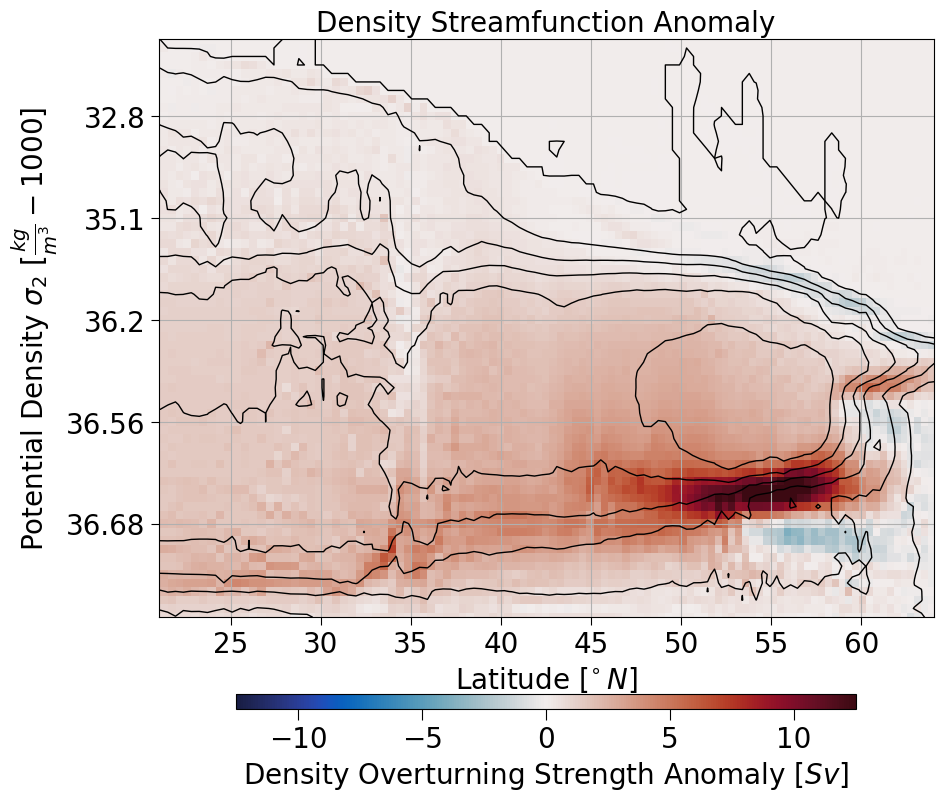

In [240]:
labelsize = 20

cbar_kwargs = {'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
               'label': 'Density Overturning Strength Anomaly [$Sv$]', 'pad': 0.1}

fig, ax = plt.subplots(figsize=(10, 10))

pc = ax.pcolormesh(ds_ps.TLAT.isel(nlat=(slice(250,365))), fake_sigma, anom_smoc_ds.densMOC,
                   cmap=cmo.balance,
                   vmin=vmin, vmax=vmax)

cbar = plt.colorbar(pc, **cbar_kwargs)
cbar.ax.xaxis.label.set_size(labelsize)
cbar.ax.tick_params(axis='x', labelsize=labelsize , size=8)

plt.contour(ds_ps.ULAT.isel(nlat=(slice(250,365))), fake_sigma, smoc_ds.densMOC.isel(time=slice(0,40)).mean('time'), 
            linewidths=1, colors='k')

ax.tick_params(axis='both', which='both', labelsize=labelsize , size=6)
ax.set_title('Density Streamfunction Anomaly', fontsize=labelsize )

plt.yticks(np.arange(len(sigma_level))[::12], sigma_level[::12])

ax.set_xlim([21, 64])  
ax.set_ylim([15, 83])  

plt.ylabel(r'Potential Density $\sigma_2$ [$\frac{kg}{m^3} -1000$]', fontsize = labelsize )
plt.xlabel(r'Latitude [$^{\circ}\,N$]', fontsize = labelsize )

plt.gca().invert_yaxis()

plt.grid()

plt.show()

#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'smoc_anomaly.png', bbox_inches='tight', dpi=300, transparent=True)